<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/Percobaan_5_Arsitektur_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data tabular binary dari citra 0 (without_pesticide) dan 10 (with_pesticide) mg/l | ROI

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the path to the directory containing the dataset
dataset_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Preprocessing/ROI/Tabular/Binary/'

In [4]:
# Load the CSV files into pandas DataFrames
df_without_pesticide = pd.read_csv(dataset_path + 'without_pesticide.csv')
df_with_pesticide = pd.read_csv(dataset_path + 'with_pesticide.csv')

# Display the first few rows of each DataFrame to inspect the data
print("First few rows of without_pesticide.csv:")
print(df_without_pesticide.head())

print("\nFirst few rows of with_pesticide.csv:")
print(df_with_pesticide.head())

First few rows of without_pesticide.csv:
               label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0  without_pesticide       0       0       0       0       0       0       0   
1  without_pesticide       0       0       0       0       0       0       0   
2  without_pesticide       0       0       0       0       0       0       0   
3  without_pesticide       0       0       0       0       0       0       0   
4  without_pesticide       0       0       0       0       0       0       0   

   pixel8  pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0       0  ...         0         0         0         0         0   
1       0       0  ...         0         0         0         0         0   
2       0       0  ...         0         0         0         0         0   
3       0       0  ...         0         0         0         0         0   
4       0       0  ...         0         0         0         0         0   

   pixel780  pixel781

In [5]:
# Convert dataframe to numpy array
X_without_pesticide = df_without_pesticide.drop('label', axis=1).values.astype('float32')
X_with_pesticide = df_with_pesticide.drop('label', axis=1).values.astype('float32')

# Assuming that your images are flattened, reshape them into 28x28
X_without_pesticide = X_without_pesticide.reshape(-1, 28, 28, 1)
X_with_pesticide = X_with_pesticide.reshape(-1, 28, 28, 1)

# Concatenate data
X = np.concatenate((X_without_pesticide, X_with_pesticide), axis=0)

# Create labels
y = np.concatenate((np.zeros(X_without_pesticide.shape[0]), np.ones(X_with_pesticide.shape[0])))

# Convert labels to categorical one-hot encoding
y = to_categorical(y)

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Define the model architecture
def VGG_16(_input = Input((28,28,1))):
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(_input)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)
    # Block 2
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)
    # Fully Connected layers
    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(2, activation='softmax')(dense2)  # Adjust output units to 2 for binary classification
    VGG16_model = Model(inputs=_input, outputs=output)
    return VGG16_model

# Instantiate the model
model = VGG_16()

# Define learning rate
learning_rate = 0.001

# Define your optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                           

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

Epoch 1/20
8/8 [==============================] - 2s 97ms/step - loss: 2.2021 - accuracy: 0.5500 - val_loss: 0.7376 - val_accuracy: 0.4500
Epoch 2/20
8/8 [==============================] - 1s 77ms/step - loss: 0.6622 - accuracy: 0.6125 - val_loss: 0.7445 - val_accuracy: 0.4000
Epoch 3/20
8/8 [==============================] - 1s 73ms/step - loss: 0.6236 - accuracy: 0.6750 - val_loss: 0.7452 - val_accuracy: 0.5167
Epoch 4/20
8/8 [==============================] - 1s 76ms/step - loss: 0.5772 - accuracy: 0.7208 - val_loss: 0.8276 - val_accuracy: 0.5000
Train Loss: 0.5771542191505432
Train Accuracy: 0.7208333611488342


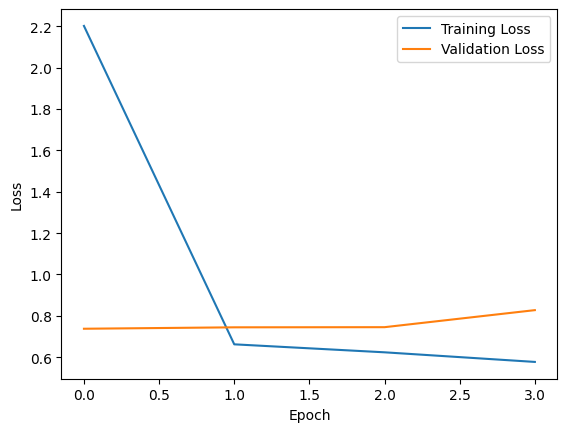

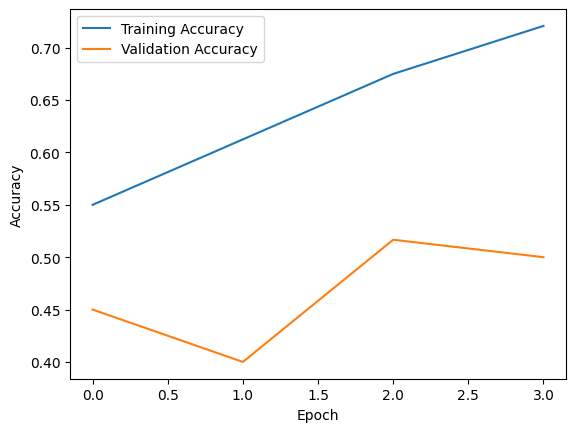

In [12]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 29ms/step


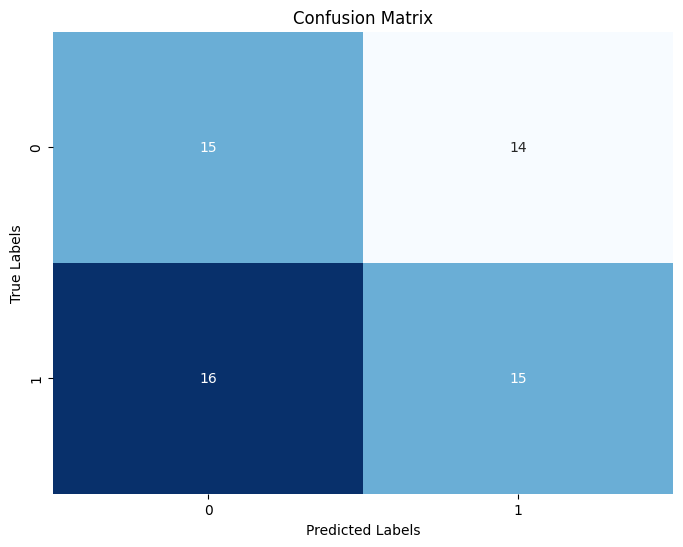

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.52      0.50        29
           1       0.52      0.48      0.50        31

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60



In [13]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Print classification report
print("Classification Report:\n", class_report)


In [14]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 5/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Tugas Akhir_Zulfa Hana Maulida(1)/Arsitektur VGG16/Percobaan 5/model.h5
